### Import libraries and modules

In [3]:
import os
from matplotlib import pyplot as plt
import numpy as np
from timeit import default_timer
import pandas as pd
import seaborn as sns

from src import detector_descriptor as dd
from src import data


In [4]:
os.chdir('..')

#### Styling methods for dataframe

In [5]:
def highlight_max(data, color='#5fba7d'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
def highlight_min(data, color='#d65f5f'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

#### Methods and variables for image dataset

In [6]:
image_set_variance = {
    'bark': 'zoom_rotation', 
    'boat': 'zoom_rotation',
    'leuven': 'light',
    'bikes': 'blur', 
    'trees': 'blur',
    'wall': 'viewpoint',
    'graf': 'viewpoint',
    'ubc': 'jpeg-compression'
}


def get_image_set(image_prefix='all'):
    all_images = data.load_data(os.path.join(os.getcwd(), 'dataset', 'pickle_dump', 'oxford.pckl'))
    if image_prefix is 'all':
        return all_images
    else:
        image_set = {}
        for key, value in all_images.items():
            if image_prefix in key:
                image_set[key] = value
        return image_set
    
    
def show_image_set(images):    
    fig, axs = plt.subplots(len(images)//3, 3, figsize=(10, 5), sharex=True, sharey=True)
    i = 0
    for img in images.values():
        axs[i//3, i%3].imshow(img)
        i += 1
    plt.show()

##### Show all images from an image set

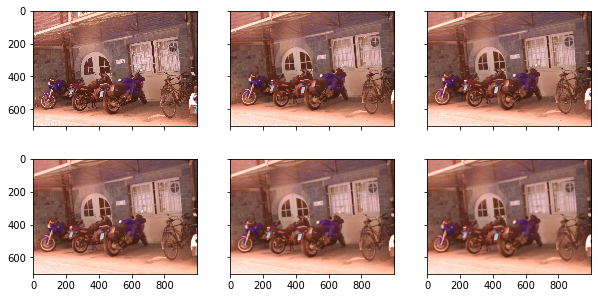

In [7]:
# all_detectors = dd.get_all_detectors()
# print(list(all_detectors.keys()))
images = get_image_set('bikes')
show_image_set(images)

#### Methods for feature detectors

In [8]:
def get_exec_time_keypoints(img):
    keypoints_by_detector = dict()
    execution_time = dict()
    all_detectors = dd.get_all_detectors()

    for name, _ in all_detectors.items():
        detector = dd.initialize_detector(name)
        start_time = default_timer()
        keypoints = detector.detect(img)
        execution_time[name] = default_timer() - start_time
        keypoints_by_detector[name] = keypoints
    return execution_time, keypoints_by_detector
# dd.print_dictionary(execution_time)

def get_exec_time_keypoints_det(image_set, detector_name):
    detector = dd.initialize_detector(detector_name)
    keypoints_by_image = dict()
    execution_time = dict()
    i = 0
    for image in image_set.values():
        start_time = default_timer()
        keypoints = detector.detect(image)
        execution_time[i] = default_timer() - start_time
        keypoints_by_image[i] = keypoints
        i += 1
    return execution_time, keypoints_by_image

def get_avg_exec_time_total_kp(image_set):
    avg_keypoints_by_detector = dict()
    avg_execution_time = dict()
    all_detectors = dd.get_all_detectors()
    num_images = len(image_set.values())
    for detector_name in all_detectors:
        avg_keypoints_by_detector[detector_name] = 0
        avg_execution_time[detector_name] = 0
    for img in image_set.values():
        execution_time, keypoints_by_detector = get_exec_time_keypoints(img)
        for detector_name in all_detectors:
            avg_keypoints_by_detector[detector_name] += len(keypoints_by_detector[detector_name])
            avg_execution_time[detector_name] += execution_time[detector_name]
    for detector_name in all_detectors:
        avg_keypoints_by_detector[detector_name] = avg_keypoints_by_detector[detector_name]//num_images
        avg_execution_time[detector_name] = avg_execution_time[detector_name]/num_images
    
    return avg_execution_time, avg_keypoints_by_detector

#### Visualize total number of keypoints vs execution time for corresponding detectors

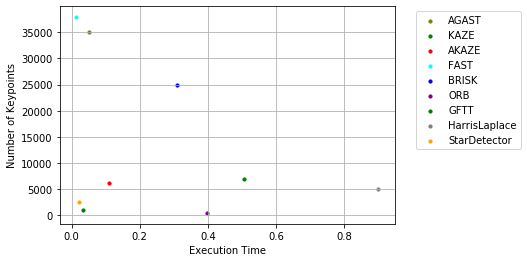

In [9]:
images = get_image_set('trees')
img = images['trees_img1']
execution_time, keypoints_by_detector = get_exec_time_keypoints(img)
fig = plt.figure()
ax = fig.add_subplot(111)
plot_data = {}
for name in execution_time.keys():
    total_keypoints = len(keypoints_by_detector[name])
    plot_data[name] = [execution_time[name], total_keypoints]
    
fig = plt.plot()

colors = ['olive', 'green', 'red', 'cyan', 'blue', 'purple', 'green', 'grey', 'orange', 'brown']
i = 0
for key, values in plot_data.items():
    x, y = values
    ax.scatter(x, y, c=colors[i], s=10, label=key)
#     ax.annotate(key, xy=(x+0.02, y), textcoords='data')
    i += 1
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.xlabel("Execution Time")
plt.ylabel("Number of Keypoints")
plt.show()


#### Number of total keypoints and execution time for each detector type

In [10]:
df = pd.DataFrame() 
df['Detector'] = plot_data.keys()
df['Execution Time'] = [values[0] for values in plot_data.values()]
df['Number of Keypoints'] = [values[1] for values in plot_data.values()]
# df=df.sort_values(by=['Execution Time'])
df.style.\
    apply(highlight_max, subset=['Execution Time', 'Number of Keypoints']).\
    apply(highlight_min, subset=['Execution Time', 'Number of Keypoints'])

,Detector,Execution Time,Number of Keypoints
0,AGAST,0.051040,35028
1,KAZE,0.506783,6996
2,AKAZE,0.111183,6118
3,FAST,0.012103,37850
4,BRISK,0.310820,24988
5,ORB,0.398073,500
6,GFTT,0.032430,1000
7,HarrisLaplace,0.901363,5000
8,StarDetector,0.021300,2539


#### Gradual blurring

In [11]:
image_set = get_image_set('trees')
fig, axs = plt.subplots(1, 2, figsize=(12,4), dpi=1200)

for detector_name in dd.get_all_detectors().keys():    
    execution_time, total_keypoints = get_exec_time_keypoints_det(image_set, detector_name)
#     print(execution_time)
    axs[0].plot(list(execution_time.keys()), list(execution_time.values()), label=detector_name)
    axs[1].plot(list(total_keypoints.keys()), [len(value) for value in total_keypoints.values()], label=detector_name)
axs[0].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
axs[0].set_xlabel("Image blur")
axs[0].set_ylabel("Execution Time")
# axs[0].set_yscale('log')


axs[1].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
axs[1].set_xlabel("Image blur")
axs[1].set_ylabel("Number of Keypoints")
# axs[1].set_yscale('log')

plt.show()

#### Gradual darkenning
__Todo__

- [ ] Change to bar plot
- [ ] Ask in stackoverflow about this checkbox problem

In [12]:
image_set = get_image_set('leuven')
fig, axs = plt.subplots(1, 2, figsize=(12,4), dpi=1200)

for detector_name in dd.get_all_detectors().keys():    
    execution_time, total_keypoints = get_exec_time_keypoints_det(image_set, detector_name)
#     print(execution_time)
    axs[0].plot(list(execution_time.keys()), list(execution_time.values()), label=detector_name)
    axs[1].plot(list(total_keypoints.keys()), [len(value) for value in total_keypoints.values()], label=detector_name)
axs[0].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
axs[0].set_xlabel("Image darken")
axs[0].set_ylabel("Execution Time")
# axs[0].set_yscale('log')


axs[1].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
axs[1].set_xlabel("Image darken")
axs[1].set_ylabel("Number of Keypoints")
# axs[1].set_yscale('log')

plt.show()

#### Use set to find the intersection of the keypoints to the union

In [13]:

image_set = get_image_set('bikes')
image = image_set['bikes_img1']

execution_time, total_keypoints = get_exec_time_keypoints(image)
union_keypoints = set()
union_keypoints.update(*total_keypoints.values())
# union_keypoints = *union_keypoints.pt
# print(len(all_keypoints))

__TODO__
- [ ] Find intersection
- [ ] Graph frequncy in seaborn
- [ ] List to numpy

In [27]:
from itertools import chain
def kp_obj2np(all_keypoints):
    kp_np = dict()
    for detector, keypoints in all_keypoints.items():
        keypoints_to_list = list()
        for keypoint in keypoints:
            pt = (round(keypoint.pt[0]), round(keypoint.pt[1]))
            keypoints_to_list.append(pt)
        kp_np[detector] = np.array(keypoints_to_list)
        # keypoints_to_list.clear()
    return kp_np
kp_np = kp_obj2np(total_keypoints)
kp_all = np.array(list(chain(*[value.tolist() for value in kp_np.values()])))
kp_all = np.unique(kp_all, axis=0)
# b = list(chain(*[value.tolist() for value in kp_np.values()]))
# a = set([tuple(el) for el in b])
# a.update(b)
# print(len(a))
print(kp_all.shape)
# print(union_keypoints)

(19924, 2)


In [30]:
# keypoint_list = list(union_keypoints)
# print(keypoint_list )
point_freq = np.zeros((kp_all.shape[0],1))
for i in range(0, kp_all.shape[0]):
    for detector in dd.get_all_detectors().keys():
        if kp_all[i] in kp_np[detector]:
            point_freq[i] += 1
print(point_freq)

[[2.]
 [2.]
 [4.]
 ...
 [7.]
 [9.]
 [6.]]


In [33]:
kp = np.hstack((kp_all, point_freq))
print(kp)
# plt.imshow(image)
# plt.show()

[[  3.   6.   2.]
 [  3.  14.   2.]
 [  3.  16.   4.]
 ...
 [997. 549.   7.]
 [998. 489.   9.]
 [998. 606.   6.]]


In [ ]:
max(point_freq)

In [ ]:
# plt.plot(range(0, len(point_freq)), point_freq)
# sns.relplot(x="total_bill", y="tip", data=[range(0, len(point_freq)), point_freq])
sns.set()
plt.scatter([x for (x,y) in keypoint_list], [700-y for (x,y) in keypoint_list], s=point_freq)
plt.show()

In [ ]:
intersection_keypoints = union_keypoints
for detector_name, keypoints in total_keypoints.items():
    print(detector_name)
    keypoints = set()
    keypoints.update(total_keypoints[detector_name])
    intersection_keypoints.intersection_update(keypoints)
    keypoints.clear()
print(len(intersection_keypoints))

In [ ]:
def get_exec_time_keypoints(img):
    keypoints_by_detector = dict()
    execution_time = dict()
    all_detectors = dd.get_all_detectors()

    for name, _ in all_detectors.items():
        detector = dd.initialize_detector(name)
        start_time = default_timer()
        keypoints = detector.detect(img)
        execution_time[name] = default_timer() - start_time
        keypoints_by_detector[name] = keypoints
    return execution_time, keypoints_by_detector

#### Visualize average total number of keypoints vs average execution time for corresponding detectors for a certain image set

In [ ]:
image_set = get_image_set('trees')
avg_execution_time, avg_total_keypoints = get_avg_exec_time_total_kp(image_set)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_data = {}
for name in avg_execution_time.keys():
#     total_keypoints = len(keypoints_by_detector[name])
    plot_data[name] = [avg_execution_time[name], avg_total_keypoints[name]]
    
fig = plt.plot()

colors = ['olive', 'green', 'red', 'cyan', 'blue', 'purple', 'green', 'grey', 'orange', 'brown']
i = 0
for key, values in plot_data.items():
    x, y = values
    ax.scatter(x, y, c=colors[i], s=10, label=key)
#     ax.annotate(key, xy=(x+0.02, y), textcoords='data')
    i += 1
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.xlabel("Execution Time")
plt.ylabel("Number of Keypoints")
plt.show()

In [ ]:
df = pd.DataFrame() 
df['Detector'] = plot_data.keys()
df['Execution Time'] = [values[0] for values in plot_data.values()]
df['Number of Keypoints'] = [values[1] for values in plot_data.values()]
# df=df.sort_values(by=['Execution Time'])
df.style.\
    apply(highlight_max, subset=['Execution Time', 'Number of Keypoints']).\
    apply(highlight_min, subset=['Execution Time', 'Number of Keypoints'])

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
i = 0
for key, values in key_points_by_detector.items():
    pts = np.asarray([[p.pt[0], p.pt[1]] for p in values])
    x = pts[:,0]
    y = pts[:,1]
    axs[i//3, i%3].set_title(key)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].scatter(x, y, c='r', s=2)
    i += 1
plt.show()